Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns                       
import matplotlib.pyplot as plt  

Lendo os dados

In [2]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)
datasets = {'portfolio': portfolio
            ,'profile': profile
            ,'transcript': transcript}


Separando o dicionário da coluna 'value' nas colunas 'offer_id' e 'amount'

In [3]:
transcript_exp = transcript.copy()
value_expanded = pd.json_normalize(transcript_exp['value'])
transcript_exp = pd.concat([transcript_exp.drop(columns='value'), value_expanded], axis=1)

Normalizando o nome da coluna 'offer_id' e 'offer id'

In [4]:
transcript_exp['offer_id'] = transcript_exp.get('offer id', pd.NA).fillna(transcript_exp.get('offer_id'))

Dando merge nas tabela transcript e portfolio usando a chave 'offer_id' e 'id'

In [5]:
raw_data = pd.merge(transcript_exp, portfolio, left_on='offer_id', right_on='id', how='left')

Alterando a coluna 'time' que está em horas, para dias, para ficar na mesma unidade de medidade que a coluna 'duration' das ofertas

In [6]:
raw_data['time'] = raw_data['time']/24

Criando base somente com as ofertas

In [7]:
offers = raw_data[raw_data['event'].isin(['offer received'])].copy()

In [8]:
offers = offers.rename(columns={'time': 'received_time'})

In [ ]:
offers.head(10)

Incluindo variáveis com dados das transações

In [10]:
transactions = transcript_exp[transcript_exp['event'] == 'transaction'].copy()
transactions = transactions[['person', 'time', 'amount']]

In [11]:
# Ajustar o time da transactions pra ser em dias também
transactions['time'] = transactions['time']/24

In [13]:
offers_tx = offers[['person', 'offer_id', 'received_time']].copy()
offers_tx = offers_tx.sort_values(['person', 'received_time']).copy()

# Adicionar tempo da oferta anterior da mesma pessoa
offers_tx['previous_received_time'] = (
    offers_tx.groupby('person')['received_time'].shift(1)
)

# Para quem não tinha nenhuma oferta antes, define como -inf
offers_tx['previous_received_time'] = offers_tx['previous_received_time'].fillna(-float('inf'))

In [14]:
merged = transactions.merge(offers_tx, on='person', how='inner')

# Filtrar transações entre a oferta anterior e a atual
mask = (
    (merged['time'] >= merged['previous_received_time']) &
    (merged['time'] < merged['received_time'])
)
merged = merged[mask]

In [15]:
agg = merged.groupby(['person', 'offer_id', 'received_time']).agg(
    pre_offer_avg_spend=('amount', 'mean'),
    pre_offer_num_tx=('amount', 'count'),
    last_tx_time=('time', 'max')
).reset_index()

# Calcular tempo desde última transação
agg['pre_offer_time_since_last_tx'] = agg['received_time'] - agg['last_tx_time']

In [16]:
offers = offers.merge(
    agg,
    on=['person', 'offer_id', 'received_time'],
    how='left'
)

In [ ]:
transcript[transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

In [200]:
offers[offers['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,person,event,received_time,offer id,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,id,pre_offer_avg_spend,pre_offer_num_tx,last_tx_time,pre_offer_time_since_last_tx
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN
25357,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,14.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,26.838333,6.0,8.50,5.50
38069,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,17.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,28.505000,4.0,16.75,0.25
50844,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,21.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,21.130000,1.0,19.75,1.25


Unindo a base das ofertas com a base dos perfis

In [17]:
data = pd.merge(offers, profile, how='left', left_on='person', right_on='id')

Removendo as últimas colunas inúteis antes de começarmos a análisar realmente as variáveis

In [18]:
data.drop(['event', 'offer_id', 'person', 'last_tx_time', 'amount', 'reward_x', 'offer id', 'id_x', 'id_y'], axis=1, inplace=True)

In [19]:
data.head(10)

,received_time,reward_y,channels,difficulty,duration,offer_type,pre_offer_avg_spend,pre_offer_num_tx,pre_offer_time_since_last_tx,gender,age,became_member_on,income
0,0.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,NaN,NaN,NaN,F,75,20170509,100000.0
1,0.0,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaN,None,118,20170804,NaN
2,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount,NaN,NaN,NaN,M,68,20180426,70000.0
3,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,NaN,NaN,NaN,None,118,20170925,NaN
4,0.0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,NaN,NaN,NaN,None,118,20171002,NaN
5,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,NaN,NaN,NaN,M,65,20180209,53000.0
6,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,NaN,NaN,NaN,None,118,20170824,NaN
7,0.0,0.0,"[web, email, mobile]",0.0,4.0,informational,NaN,NaN,NaN,M,58,20171111,51000.0
8,0.0,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaN,F,61,20170911,57000.0
9,0.0,5.0,"[web, email]",20.0,10.0,discount,NaN,NaN,NaN,F,62,20160211,71000.0


Análisando as variáveis

<Axes: xlabel='age', ylabel='Count'>

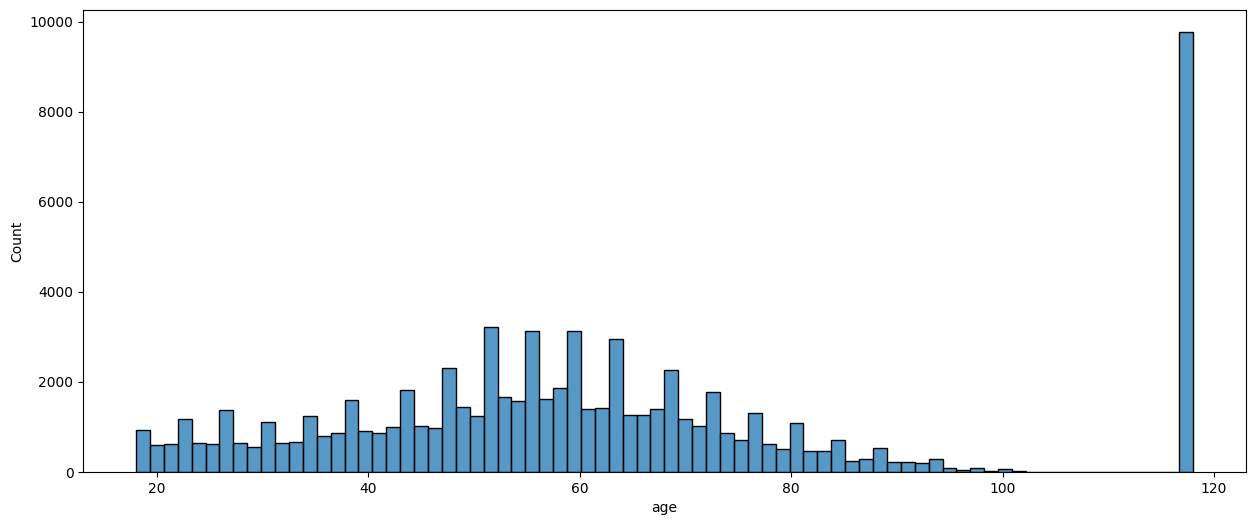

In [208]:
plt.figure(figsize=(15,6))
sns.histplot(data=data, x='age')

<Axes: xlabel='income', ylabel='Count'>

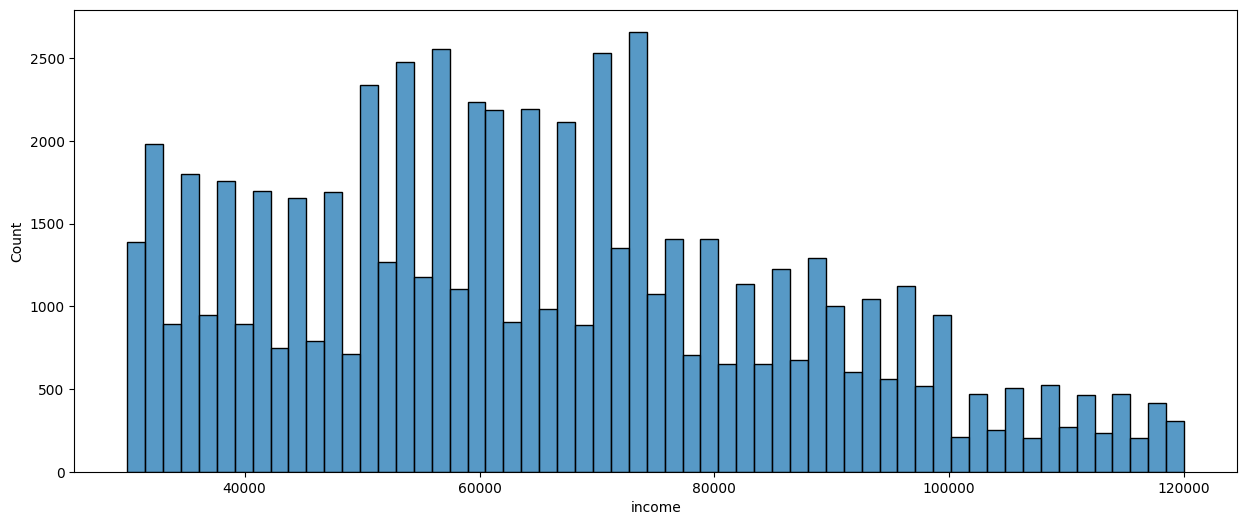

In [210]:
plt.figure(figsize=(15,6))
sns.histplot(data=data, x='income')

Separar base transcript pelas transações

/tmp/ipykernel_3080/581629909.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='offer_type', palette="viridis")


<Axes: xlabel='offer_type', ylabel='count'>

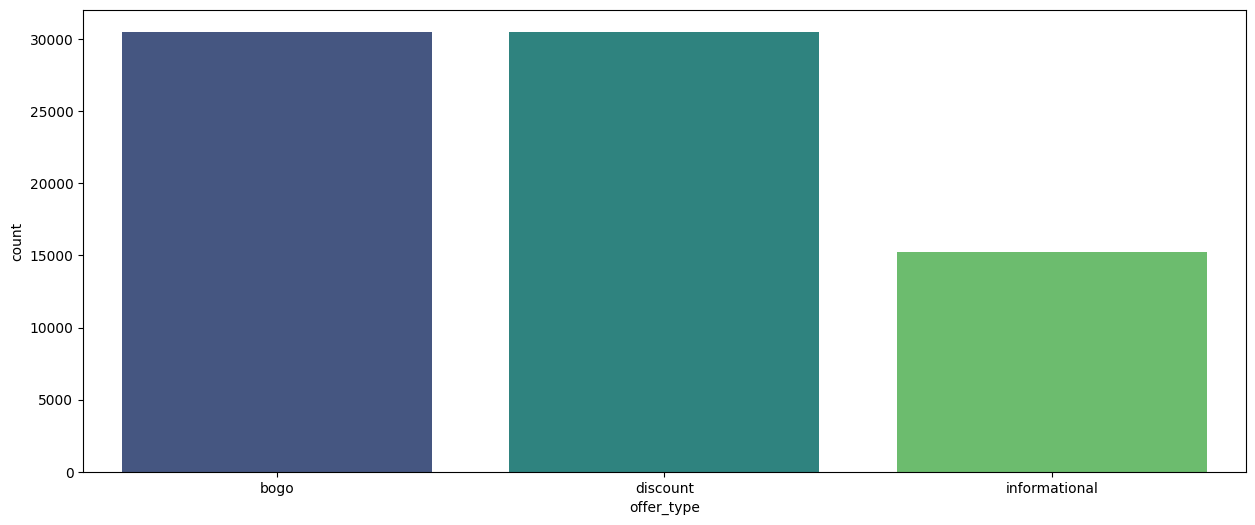

In [211]:
plt.figure(figsize=(15,6))
sns.countplot(data=data, x='offer_type', palette="viridis")

Valores missing

In [215]:
# Gráfico com porcentagem de valores ausentes (somente colunas com algum valor ausente)
def plot_missing_percent(df):

    # 1. Calcular percentual de missing por coluna
    missing_pct = df.isna().mean() * 100
    missing_pct = missing_pct[missing_pct > 0]

    # 2. Verificar se há valores ausentes
    if missing_pct.empty:
        print("✅ Nenhuma coluna com valores ausentes.")
        return

    # 3. Plotar gráfico de barras
    plt.figure(figsize=(10, 6))
    missing_pct.sort_values(ascending=False).plot(kind='bar')

    plt.title('Percentual de valores ausentes por coluna')
    plt.ylabel('% de valores ausentes')
    plt.xlabel('Colunas')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

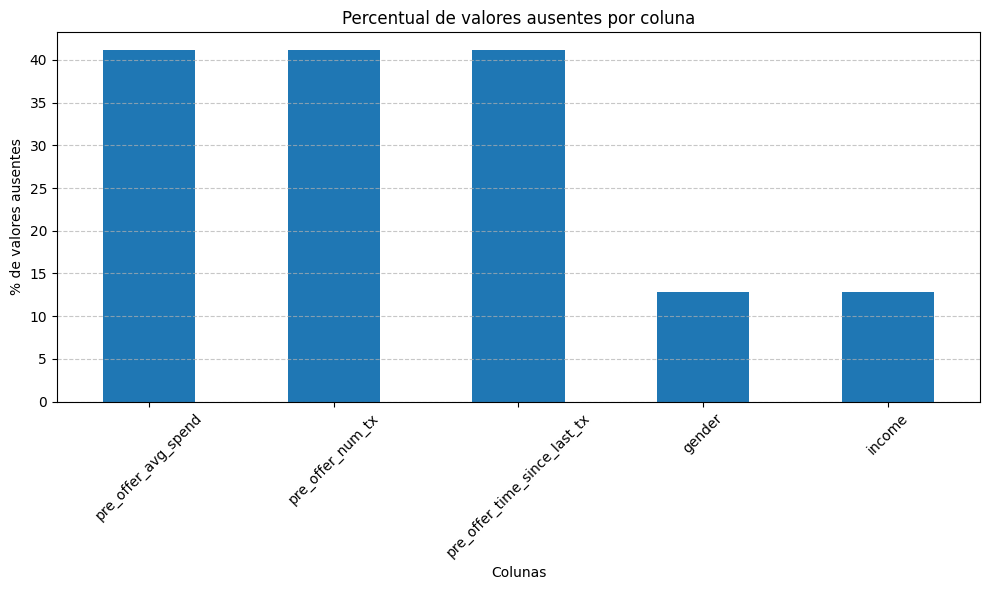

In [216]:
plot_missing_percent(data)